Importar imágenes

In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('Dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf

In [ ]:
# Tamaño de las imágenes
IMG_HEIGHT, IMG_WIDTH = 128, 128

In [ ]:
# Directorios
image_dir = 'Dataset/Originales/'
mask_dir = 'Dataset/Masks/'


In [ ]:
# Actual
def load_data(image_dir, mask_dir):
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    images = []
    masks = []

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        # Leer imagen y redimensionar
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        images.append(img)

        # Leer máscara en color y redimensionar
        mask = cv2.imread(os.path.join(mask_dir, mask_file))  # Ahora se lee en color
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

        # Convertir la máscara a escala de grises
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        masks.append(mask)

    # Convertir a arrays numpy
    images = np.array(images) / 255.0  # Normalizar imágenes entre 0 y 1
    masks = np.array(masks).astype(np.int32)  # Asegurar que las máscaras sean enteros

    return images, masks


In [ ]:
from tensorflow.keras.utils import to_categorical

def preprocess_masks(masks, num_classes=3):
    masks = np.where(masks == 0, 0, masks)
    masks = np.where(masks == 73, 1, masks)
    masks = np.where(masks == 172, 2, masks)
    # Aplicar one-hot encoding a las máscaras
    masks = to_categorical(masks, num_classes=num_classes)  # (160, 128, 128, 3)

    return masks


In [ ]:
from sklearn.model_selection import train_test_split

# Cargar las imágenes y las máscaras
X, y = load_data(image_dir, mask_dir)
y = preprocess_masks(y)

# Dividir el conjunto de datos en 80% para train y 20% para test + valid
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir el 20% restante (X_temp, y_temp) en 10% valid y 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Mostrar las formas de cada conjunto de datos
print("Imágenes de entrenamiento (train):", X_train.shape)
print("Máscaras de entrenamiento (train):", y_train.shape)
print("Imágenes de validación (validation):", X_val.shape)
print("Máscaras de validación (validation):", y_val.shape)
print("Imágenes de prueba (test):", X_test.shape)
print("Máscaras de prueba (test):", y_test.shape)

Imágenes de entrenamiento (train): (160, 128, 128, 3)
Máscaras de entrenamiento (train): (160, 128, 128, 3)
Imágenes de validación (validation): (20, 128, 128, 3)
Máscaras de validación (validation): (20, 128, 128, 3)
Imágenes de prueba (test): (20, 128, 128, 3)
Máscaras de prueba (test): (20, 128, 128, 3)


In [ ]:
print(f"Forma de las imágenes: {X.shape}")
print(f"Forma de las máscaras: {y.shape}")
print(f"Valores únicos en las máscaras: {np.unique(np.argmax(y, axis=-1))}")

Forma de las imágenes: (200, 128, 128, 3)
Forma de las máscaras: (200, 128, 128, 3)
Valores únicos en las máscaras: [0 1 2]


In [ ]:
print(f"Valores únicos en las máscaras: {np.unique(np.argmax(y, axis=-1))}")
print(f"Valores únicos en las máscaras: {np.unique(np.argmax(y, axis=-1))}")
print(f"Valores únicos en las máscaras: {np.unique(np.argmax(y, axis=-1))}")

Valores únicos en las máscaras: [0 1 2]
Valores únicos en las máscaras: [0 1 2]
Valores únicos en las máscaras: [0 1 2]


In [ ]:
from tensorflow.keras import layers, Model
import tensorflow as tf

def unet(input_shape=(128, 128, 3), num_classes=3):
    inputs = layers.Input(input_shape)

    # Contracción (Downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Capa intermedia
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansión (Upsampling)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Crear el modelo para múltiples clases
num_classes = 3
model = unet(input_shape=(128, 128, 3), num_classes=num_classes)

# Compilar el modelo con categorical_crossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

# Mostrar resumen del modelo
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,031,875 (118.38 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenar el modelo
EPOCAS_ENTRENAMIENTO = 10
history = model.fit(X_train, y_train, epochs=EPOCAS_ENTRENAMIENTO, batch_size=8, validation_data=(X_val, y_val))

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 722ms/step - categorical_accuracy: 0.6204 - loss: 0.8457 - val_categorical_accuracy: 0.8787 - val_loss: 0.3081
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - categorical_accuracy: 0.8912 - loss: 0.2882 - val_categorical_accuracy: 0.8996 - val_loss: 0.2380
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - categorical_accuracy: 0.9254 - loss: 0.1945 - val_categorical_accuracy: 0.9431 - val_loss: 0.1606
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - categorical_accuracy: 0.9463 - loss: 0.1526 - val_categorical_accuracy: 0.9473 - val_loss: 0.1432
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - categorical_accuracy: 0.9515 - loss: 0.1341 - val_categorical_accuracy: 0.9511 - val_loss: 0.1342
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - categorical_accuracy: 0.9550 - loss: 0.1211 - val_categorical_accuracy: 0.9536 - val_loss: 0.1243
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - categorical_accuracy: 0.9551 - lo

In [ ]:
# Evaluar el modelo
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - categorical_accuracy: 0.9538 - loss: 0.1228
Test Loss: 0.12279566377401352
Test Accuracy: 0.9538055658340454


In [ ]:
# Realizar predicciones
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_test_classes = np.argmax(y_test, axis=-1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
from sklearn.metrics import jaccard_score

# Aplanar las máscaras y las predicciones
y_pred_flat = y_pred_classes.flatten()
y_test_flat = y_test_classes.flatten()

# Calcular IoU por clase
num_classes = len(np.unique(y_test_flat))
iou_per_class = []

for i in range(num_classes):
    iou = jaccard_score(y_test_flat == i, y_pred_flat == i, average='binary')
    iou_per_class.append(iou)

print("IoU por clase:", iou_per_class)
print("IoU promedio (mIoU):", np.mean(iou_per_class))

IoU por clase: [0.9687860937860938, 0.7407064398018522, 0.9118770548400787]
IoU promedio (mIoU): 0.8737898628093417


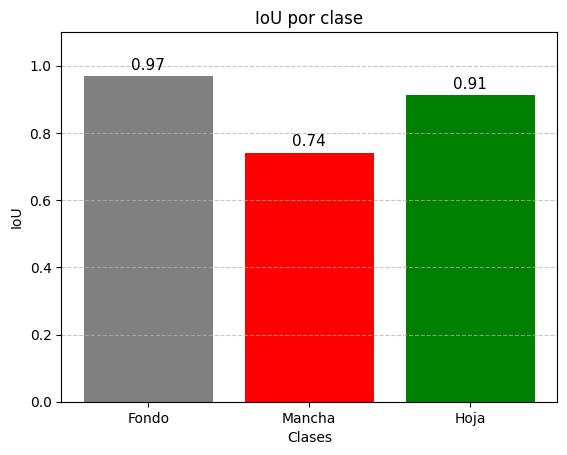

In [ ]:
import matplotlib.pyplot as plt
classes = ['Fondo', 'Mancha', 'Hoja']

plt.bar(classes, iou_per_class, color=['gray', 'red', 'green'])

for i, acc in enumerate(iou_per_class):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=11)

plt.title('IoU por clase')
plt.xlabel('Clases')
plt.ylabel('IoU')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calcular métricas por clase
precision, recall, f1, _ = precision_recall_fscore_support(y_test_flat, y_pred_flat, average=None)

print("F1 por clase:", f1)
print("F1 promedio:", np.mean(f1))

F1 por clase: [0.98090029 0.8376749  0.95308466]
F1 promedio: 0.923886616722973


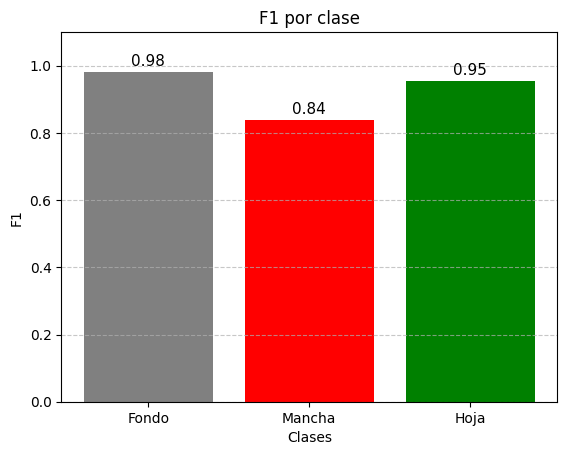

In [ ]:
plt.bar(classes, f1, color=['gray', 'red', 'green'])

for i, acc in enumerate(f1):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=11)

plt.title('F1 por clase')
plt.xlabel('Clases')
plt.ylabel('F1')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
def pixel_accuracy_per_class(y_true, y_pred, num_classes):
    correct_pixels = np.zeros(num_classes)
    total_pixels = np.zeros(num_classes)

    # Iterar por cada clase
    for class_id in range(num_classes):
        # Seleccionar los píxeles reales y predichos para la clase actual
        true_class = (y_true == class_id)
        pred_class = (y_pred == class_id)

        # Contar píxeles correctamente clasificados y totales para esta clase
        correct_pixels[class_id] = np.sum(true_class & pred_class)
        total_pixels[class_id] = np.sum(true_class)

    # Calcular pixel accuracy por clase (evitando división por cero)
    pixel_accuracy_per_class = np.divide(
        correct_pixels,
        total_pixels,
        out=np.zeros_like(correct_pixels),
        where=total_pixels != 0
    )

    return pixel_accuracy_per_class


In [ ]:
num_classes = 3

# Calcular pixel accuracy por clase
pixel_acc_class = pixel_accuracy_per_class(y_test_flat, y_pred_flat, num_classes)

for i, acc in enumerate(pixel_acc_class):
    print(f"{classes[i]}: {acc:.2f}")


Fondo: 0.98
Mancha: 0.82
Hoja: 0.96


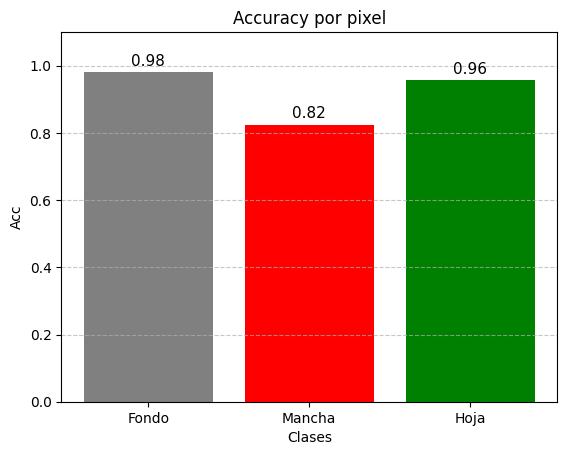

In [ ]:
plt.bar(classes, pixel_acc_class, color=['gray', 'red', 'green'])

for i, acc in enumerate(pixel_acc_class):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=11)

plt.title('Accuracy por pixel')
plt.xlabel('Clases')
plt.ylabel('Acc')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import random
import matplotlib.pyplot as plt

In [ ]:
def plot_training_history(history, afinacion = False):
    # Extraer los datos del historial
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Crear una figura para las gráficas
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Graficar precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Precisión de Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Precisión de Validación')
    plt.legend(loc='lower right')
    plt.title('Precisión en Entrenamiento y Validación')
    if afinacion:
      plt.plot([EPOCAS_ENTRENAMIENTO - 1, EPOCAS_ENTRENAMIENTO - 1],
      plt.ylim(), label='Inicio afinacion')

    # Graficar pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida en Entrenamiento y Validación')

    if afinacion:
      plt.plot([EPOCAS_ENTRENAMIENTO - 1, EPOCAS_ENTRENAMIENTO - 1],
      plt.ylim(), label='Inicio afinacion')

    # Mostrar las gráficas
    plt.show()

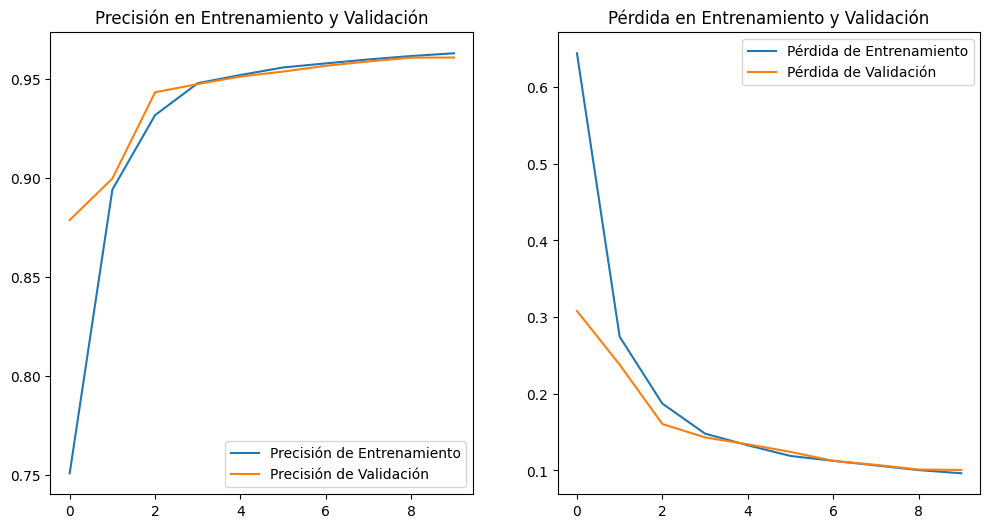

In [ ]:
plot_training_history(history, False)

In [ ]:
# Colormap
colormap = [
    [255, 255, 255],   # Fondo
    [0, 0, 255],    # Manchas
    [0, 102, 0],   # Hoja predicha
]

def apply_colormap(mask, colormap):
    """Aplica un colormap a una máscara multiclase."""
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for class_idx, color in enumerate(colormap):
        colored_mask[mask == class_idx] = color

    return colored_mask

def predecir(modelPred, index, cant=1):
    for i in range(cant):
        #index = random.randint(0, len(X_test) - 1)
        test_image = X_test[index]
        true_mask = y_test[index]

        # Preprocesar la imagen para la predicción
        test_image_input = np.expand_dims(test_image, axis=0)

        # Hacer la predicción
        predicted_mask = modelPred.predict(test_image_input)

        # Convertir la predicción a índices de clases
        predicted_mask_class = np.argmax(predicted_mask[0], axis=-1).astype(np.uint8)

        # Aplicar el colormap a la máscara predicha
        colored_mask = apply_colormap(predicted_mask_class, colormap)

        # Convertir test_image a formato uint8 si no lo está
        test_image_uint8 = (test_image * 255).astype(np.uint8)

        # Superponer la máscara sobre la imagen original
        overlayed_image = cv2.addWeighted(test_image_uint8, 0.5, colored_mask, 0.5, 0)

        # Convertir BGR a RGB para visualización en matplotlib
        test_image_rgb = cv2.cvtColor(test_image_uint8, cv2.COLOR_BGR2RGB)
        overlayed_image_rgb = cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB)

        # Mostrar la imagen original y la superposición
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title('Imagen Original')
        plt.imshow(test_image_rgb)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Superposición de la Máscara Predicha')
        plt.imshow(overlayed_image_rgb)
        plt.axis('off')

        plt.show()

In [ ]:
def calcular_proporcion(model, image):
    # Preprocesar la imagen
    input_image = np.expand_dims(image, axis=0)  # Expandir dimensiones para el modelo

    # Obtener la predicción de la máscara
    predicted_mask = model.predict(input_image)
    predicted_mask_class = np.argmax(predicted_mask[0], axis=-1)

    # Calcular el área de las clases
    area_manchas = np.sum(predicted_mask_class == 1)
    area_hoja = np.sum(predicted_mask_class == 2)

    # Calcular proporción de área afectada
    area_total = area_manchas + area_hoja
    if area_total == 0:  # Evitar división por cero
        return 0

    proporcion_afectada = area_manchas / area_total
    return proporcion_afectada

In [ ]:
# Ejemplo de uso
index = random.randint(0, len(X_test) - 1)
test_image = X_test[index]
proporcion = calcular_proporcion(model, test_image)
print(f"Proporción de área afectada: {proporcion:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Proporción de área afectada: 12.48%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


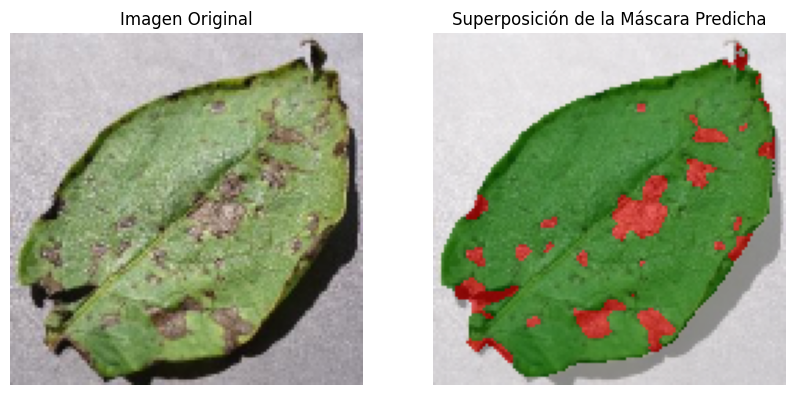

In [ ]:
predecir(model, index)

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
augment_layer = Augment()

# Crear un generador que aplica aumentación
def data_generator(X, y, batch_size):
    while True:
        # Seleccionar índices aleatorios
        idx = np.random.randint(0, len(X), batch_size)
        X_batch = X[idx]
        y_batch = y[idx]

        # Aplicar aumentación
        X_batch, y_batch = augment_layer(X_batch, y_batch)

        yield X_batch, y_batch

In [ ]:
# Parámetros del entrenamiento
BATCH_SIZE = 8
train_gen = data_generator(X_train, y_train, BATCH_SIZE)

In [ ]:
from tensorflow import keras

def segnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    # Bloque 1
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    block1_output = layers.MaxPooling2D((2, 2))(x)

    # Bloque 2
    x = layers.Conv2D(128, (3, 3), padding='same')(block1_output)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    block2_output = layers.MaxPooling2D((2, 2))(x)

    # Bloque 3
    x = layers.Conv2D(256, (3, 3), padding='same')(block2_output)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    block3_output = layers.MaxPooling2D((2, 2))(x)

    # Bloque 4
    x = layers.Conv2D(512, (3, 3), padding='same')(block3_output)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    block4_output = layers.MaxPooling2D((2, 2))(x)

    # Bloque 5
    x = layers.Conv2D(512, (3, 3), padding='same')(block4_output)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    block5_output = layers.MaxPooling2D((2, 2))(x)

    # Decoder
    # Bloque 5
    x = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(block5_output)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Bloque 4
    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Bloque 3
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Bloque 2
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Bloque 1
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(num_classes, (3, 3), padding='same')(x)

    # Capa de salida
    outputs = layers.Conv2D(num_classes, (3, 3), padding='same', activation="softmax")(x)
    outputs = layers.Activation('softmax')(outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Métrica a monitorizar
    factor=0.5,           # Reduce el LR a la mitad
    patience=3,           # Número de épocas sin mejora antes de reducir el LR
    min_lr=1e-6,          # LR mínimo
    verbose=1
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitorizar la pérdida en el conjunto de validación
    patience=10,                # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)

In [ ]:
class_weights = {0: 1.0, 1: 5.8, 2: 1.0}

In [ ]:
input_shape = (128, 128, 3)
num_classes = 3

model_segnet = segnet(input_shape, num_classes)
model_segnet.compile(optimizer='adam',
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [ ]:
def get_sample_weights(y_true, class_weights):
    class_indices = y_true.argmax(axis=-1).flatten()
    sample_weights = [class_weights[class_index] for class_index in class_indices]
    sample_weights = np.array(sample_weights).reshape(y_true.shape[:-1])

    return sample_weights

In [ ]:
# Generate sample weights for your training data
sample_weights = get_sample_weights(y_train, class_weights)

In [ ]:
EPOCAS_ENTRENAMIENTO = 100
history = model_segnet.fit(
    X_train, y_train, epochs=EPOCAS_ENTRENAMIENTO, batch_size=8, validation_data=(X_val, y_val),
    callbacks=[reduce_lr,early_stopping],
    sample_weight=sample_weights
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 204ms/step - categorical_accuracy: 0.3731 - loss: 1.4716 - val_categorical_accuracy: 0.4451 - val_loss: 1.0813 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - categorical_accuracy: 0.5159 - loss: 1.4090 - val_categorical_accuracy: 0.1835 - val_loss: 1.3717 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - categorical_accuracy: 0.7256 - loss: 1.2089 - val_categorical_accuracy: 0.1586 - val_loss: 1.3933 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_accuracy: 0.7643 - loss: 1.1671
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - categorical_accuracy: 0.7643 - loss: 1.1659 - val_categorical_accuracy: 0.4379 - val_loss: 1.1075 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - categorical_accuracy: 0.7861 - loss: 1.1074 - val_categorical_accuracy: 0.5049

In [ ]:
# Evaluar el modelo
loss, acc = model_segnet.evaluate(X_test, y_test)
print(f'Pérdida: {loss}, Precisión: {acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - categorical_accuracy: 0.8711 - loss: 0.6765
Pérdida: 0.6765128970146179, Precisión: 0.871105968952179


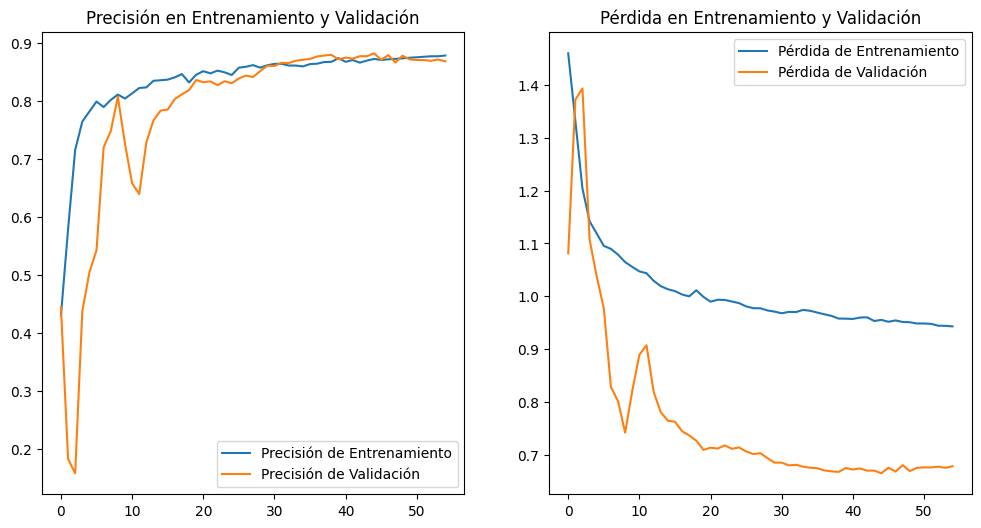

In [ ]:
plot_training_history(history, False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


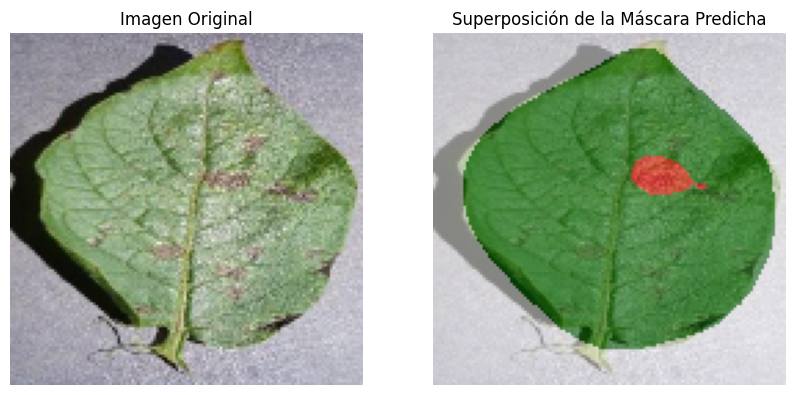

In [ ]:
# Predecir
index = random.randint(0, len(X_test) - 1)
predecir(model_segnet, index)

In [ ]:
# Realizar predicciones
y_pred = model_segnet.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_test_classes = np.argmax(y_test, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
# Aplanar las máscaras y las predicciones
y_pred_flat = y_pred_classes.flatten()
y_test_flat = y_test_classes.flatten()

# Calcular IoU por clase
num_classes = len(np.unique(y_test_flat))
iou_per_class = []

for i in range(num_classes):
    iou = jaccard_score(y_test_flat == i, y_pred_flat == i, average='binary')
    iou_per_class.append(iou)

print("IoU por clase:", iou_per_class)
print("IoU promedio (mIoU):", np.mean(iou_per_class))

IoU por clase: [0.9215001313537962, 0.41654270591898157, 0.7682834971184332]
IoU promedio (mIoU): 0.7021087781304036


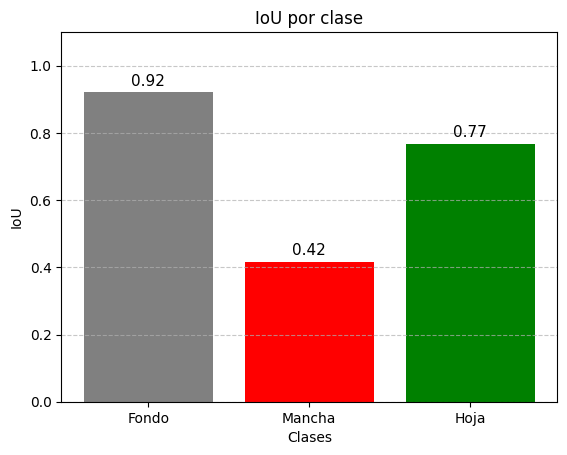

In [ ]:
plt.bar(classes, iou_per_class, color=['gray', 'red', 'green'])

for i, acc in enumerate(iou_per_class):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=11)

plt.title('IoU por clase')
plt.xlabel('Clases')
plt.ylabel('IoU')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Calcular métricas por clase
precision, recall, f1, _ = precision_recall_fscore_support(y_test_flat, y_pred_flat, average=None)

print("F1 por clase:", f1)
print("F1 promedio:", np.mean(f1))

F1 por clase: [0.95914657 0.58811175 0.86895964]
F1 promedio: 0.8054059881870836


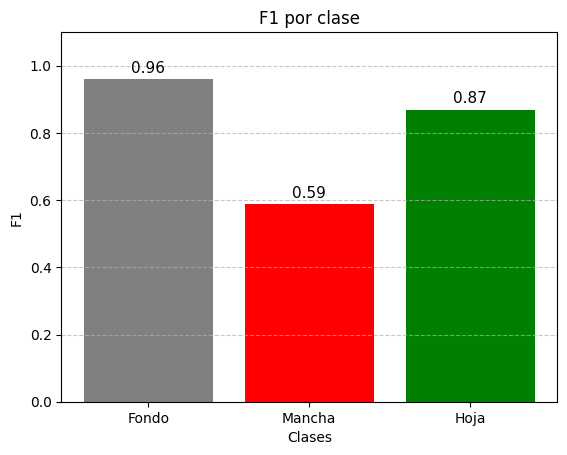

In [ ]:
plt.bar(classes, f1, color=['gray', 'red', 'green'])

for i, acc in enumerate(f1):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=11)

plt.title('F1 por clase')
plt.xlabel('Clases')
plt.ylabel('F1')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
num_classes = 3

# Calcular pixel accuracy por clase
pixel_acc_class = pixel_accuracy_per_class(y_test_flat, y_pred_flat, num_classes)

for i, acc in enumerate(pixel_acc_class):
    print(f"{classes[i]}: {acc:.2f}")

Fondo: 0.95
Mancha: 0.60
Hoja: 0.87


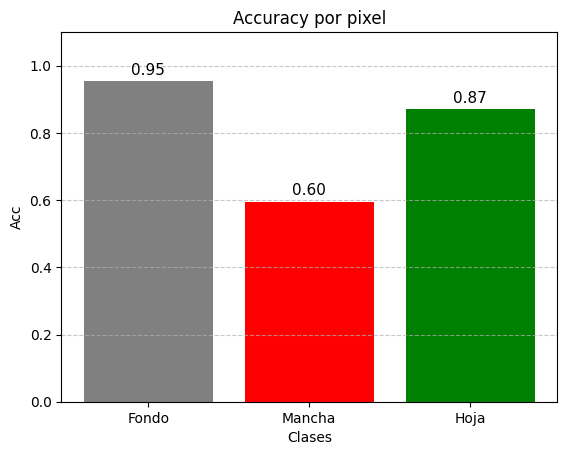

In [ ]:
plt.bar(classes, pixel_acc_class, color=['gray', 'red', 'green'])

for i, acc in enumerate(pixel_acc_class):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=11)

plt.title('Accuracy por pixel')
plt.xlabel('Clases')
plt.ylabel('Acc')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cargar el modelo DeepLabV3 preentrenado
base_model = tf.keras.applications.DenseNet201(input_shape=(None, None, 3), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=(128, 128, 3))
x = base_model(inputs)

# Convoluciones adicionales
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Progresivo upsampling para recuperar el tamaño original
x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)

# Capa de salida
outputs = layers.Conv2D(3, (1, 1), activation='softmax')(x)


In [ ]:
model_deeplab = tf.keras.Model(inputs, outputs)

# Compilación del modelo
model_deeplab.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
# Entrenamiento del modelo
history = model_deeplab.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8,
    callbacks=[reduce_lr],
    sample_weight=sample_weights)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - categorical_accuracy: 0.3382 - loss: 1.5530 - val_categorical_accuracy: 0.2749 - val_loss: 1.3928 - learning_rate: 0.0010
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - categorical_accuracy: 0.3517 - loss: 1.3710 - val_categorical_accuracy: 0.5042 - val_loss: 0.9102 - learning_rate: 0.0010
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - categorical_accuracy: 0.5313 - loss: 1.1396 - val_categorical_accuracy: 0.6211 - val_loss: 0.8274 - learning_rate: 0.0010
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - categorical_accuracy: 0.7005 - loss: 0.9299 - val_categorical_accuracy: 0.6332 - val_loss: 0.7249 - learning_rate: 0.0010
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - categorical_accuracy: 0.7297 - loss: 0.7969 - val_categorical_accuracy: 0.5727 - val_loss: 0.8039 - learning_rate: 0.0010
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - categorical_accuracy: 0.7213 - loss: 0.7901 - val_categorical_accuracy: 0

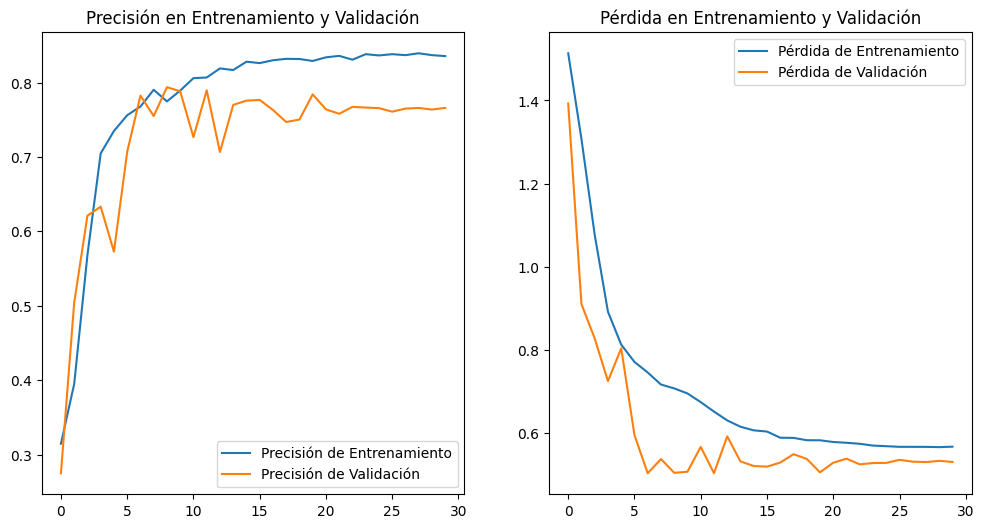

In [ ]:
plot_training_history(history, False)

In [ ]:
loss, acc = model_deeplab.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - categorical_accuracy: 0.7278 - loss: 0.5758
Test Loss: 0.5757895708084106
Test Accuracy: 0.7277862429618835


In [ ]:
# Realizar predicciones
y_pred = model_deeplab.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_test_classes = np.argmax(y_test, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


In [ ]:
# Aplanar las máscaras y las predicciones
y_pred_flat = y_pred_classes.flatten()
y_test_flat = y_test_classes.flatten()

# Calcular IoU por clase
num_classes = len(np.unique(y_test_flat))
iou_per_class = []

for i in range(num_classes):
    iou = jaccard_score(y_test_flat == i, y_pred_flat == i, average='binary')
    iou_per_class.append(iou)

print("IoU por clase:", iou_per_class)
print("IoU promedio (mIoU):", np.mean(iou_per_class))

IoU por clase: [0.8562986024070405, 0.26306892196931275, 0.505919555973749]
IoU promedio (mIoU): 0.5417623601167008


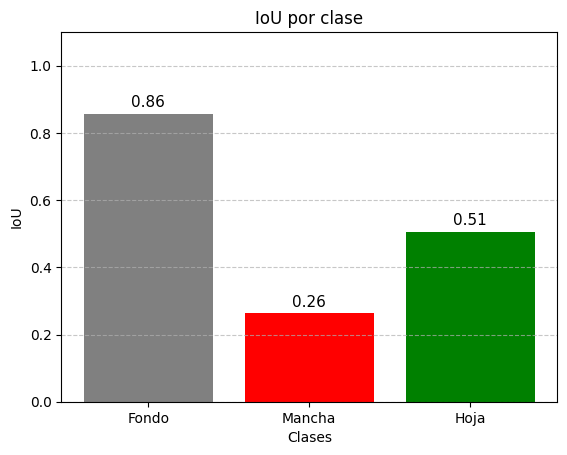

In [ ]:
plt.bar(classes, iou_per_class, color=['gray', 'red', 'green'])

for i, acc in enumerate(iou_per_class):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=11)

plt.title('IoU por clase')
plt.xlabel('Clases')
plt.ylabel('IoU')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Calcular métricas por clase
precision, recall, f1, _ = precision_recall_fscore_support(y_test_flat, y_pred_flat, average=None)

print("F1 por clase:", f1)
print("F1 promedio:", np.mean(f1))

F1 por clase: [0.92258713 0.41655513 0.67190781]
F1 promedio: 0.6703500257345852


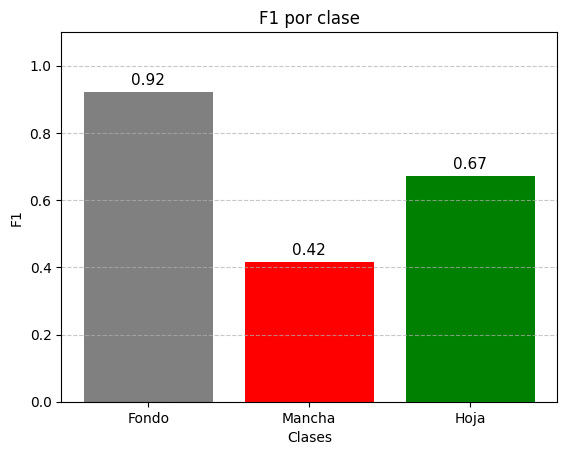

In [ ]:
plt.bar(classes, f1, color=['gray', 'red', 'green'])

for i, acc in enumerate(f1):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=11)

plt.title('F1 por clase')
plt.xlabel('Clases')
plt.ylabel('F1')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
num_classes = 3

# Calcular pixel accuracy por clase
pixel_acc_class = pixel_accuracy_per_class(y_test_flat, y_pred_flat, num_classes)

for i, acc in enumerate(pixel_acc_class):
    print(f"{classes[i]}: {acc:.2f}")

Fondo: 0.93
Mancha: 0.65
Hoja: 0.56


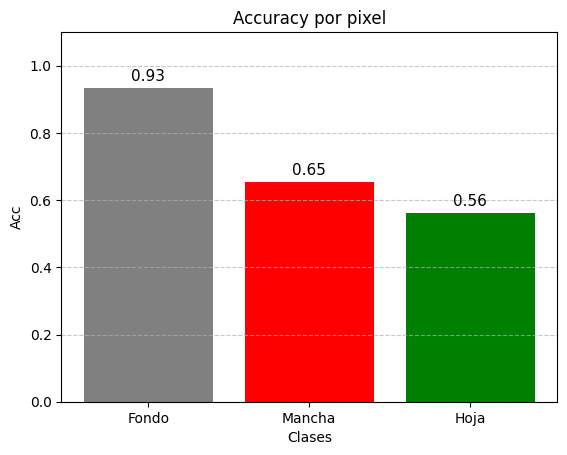

In [ ]:
plt.bar(classes, pixel_acc_class, color=['gray', 'red', 'green'])

for i, acc in enumerate(pixel_acc_class):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=11)

plt.title('Accuracy por pixel')
plt.xlabel('Clases')
plt.ylabel('Acc')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


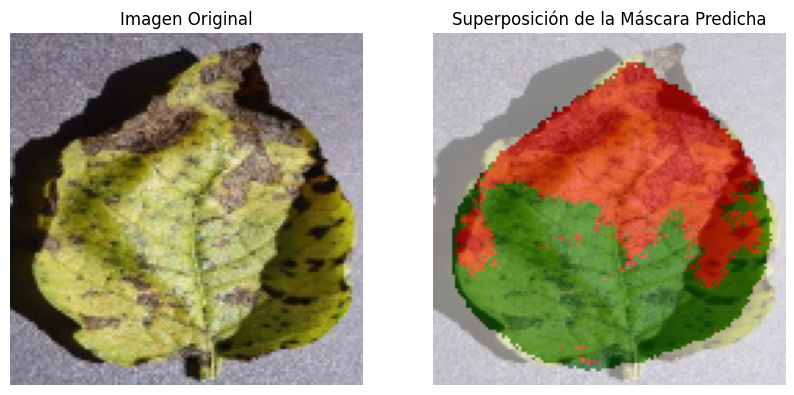

In [ ]:
index = random.randint(0, len(X_test) - 1)
predecir(model_deeplab, index)

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
import tensorflow as tf

# Definir una función para construir el modelo
def build_model(hp):
    # Ajustar learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])  # Este se utiliza durante el entrenamiento

    # Crear modelo U-Net
    num_classes = 3
    model = unet(input_shape=(128, 128, 3), num_classes=num_classes)

    # Compilar el modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    return model

# Configurar el tuner para optimización
tuner = kt.RandomSearch(
    build_model,
    objective='val_categorical_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='unet_hyperparameter_optimization'
)

# Iniciar búsqueda
tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10
)

# Recuperar los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Mejor learning rate: {best_hps.get('learning_rate')}")
print(f"Mejor batch size: {best_hps.get('batch_size')}")

# Entrenar el modelo con los mejores hiperparámetros
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=best_hps.get('batch_size'),
    epochs=30
)

Trial 9 Complete [00h 02m 27s]
val_categorical_accuracy: 0.7713287472724915

Best val_categorical_accuracy So Far: 0.9323059320449829
Total elapsed time: 00h 17m 14s
Mejor learning rate: 0.001
Mejor batch size: 16
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - categorical_accuracy: 0.4726 - loss: 1.1179 - val_categorical_accuracy: 0.8263 - val_loss: 0.6355
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 222ms/step - categorical_accuracy: 0.8388 - loss: 0.5351 - val_categorical_accuracy: 0.8793 - val_loss: 0.2980
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - categorical_accuracy: 0.8745 - loss: 0.3111 - val_categorical_accuracy: 0.8802 - val_loss: 0.2860
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - categorical_accuracy: 0.9021 - loss: 0.2611 - val_categorical_accuracy: 0.9184 - val_loss: 0.2134
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - categorical_accuracy: 0.9321 - loss: 0.1899 - val_categorical_accuracy: 0.9408 - val_loss: 0.1692
Epoch 6/30
10/10 ━━━━━━━━━━

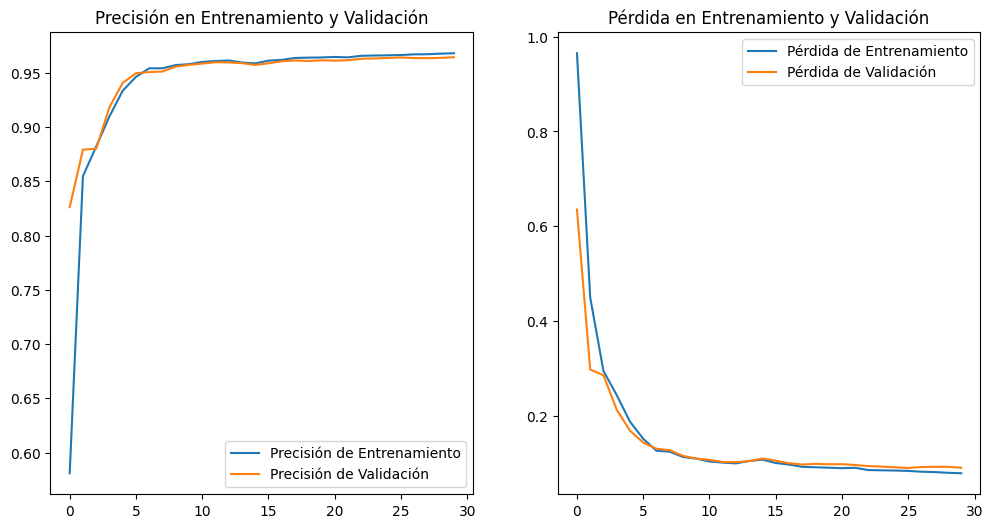

In [ ]:
plot_training_history(history, False)

In [ ]:
# Evaluar el modelo
loss, acc = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - categorical_accuracy: 0.9538 - loss: 0.1228
Test Loss: 0.12279566377401352
Test Accuracy: 0.9538055658340454


In [ ]:
# Guardar el modelo como SavedModel
best_model.save('medir.keras')

In [ ]:
from tensorflow import keras

modelCel = keras.models.load_model('medir.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(modelCel)
tflite_model = converter.convert()

# Guardar el modelo TFLite
with open('medir.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp59ycpc92'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Captures:
  134272964200752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964266464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964277200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964273680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964278608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964275264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964274384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964315616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964318960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964314384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_optimized = converter.convert()

# Guardar el modelo optimizado
with open('medir_optimized.tflite', 'wb') as f:
    f.write(tflite_model_optimized)

Saved artifact at '/tmp/tmpaamurfhf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Captures:
  134272964200752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964266464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964277200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964273680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964278608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964275264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964274384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964315616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964318960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134272964314384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134

In [ ]:
# Cargar el modelo TFLite
interpreter = tf.lite.Interpreter(model_path='medir_optimized.tflite')
interpreter.allocate_tensors()

# Verificar los detalles del modelo
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Detalles de entrada:", input_details)
print("Detalles de salida:", output_details)

Detalles de entrada: [{'name': 'serving_default_input_layer_1:0', 'index': 0, 'shape': array([  1, 128, 128,   3], dtype=int32), 'shape_signature': array([ -1, 128, 128,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Detalles de salida: [{'name': 'StatefulPartitionedCall_1:0', 'index': 98, 'shape': array([  1, 128, 128,   3], dtype=int32), 'shape_signature': array([ -1, 128, 128,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
img_test = cv2.imread('/content/t1.JPG')
img_test = cv2.resize(img_test, (IMG_WIDTH, IMG_HEIGHT))

# Normalizar los valores de la imagen a [0, 1]
img_test = img_test.astype('float32')

# Expandir las dimensiones para que sea [1, 128, 128, 3]
img_test = np.expand_dims(img_test, axis=0)

In [ ]:
# Asignar la imagen como entrada
interpreter.set_tensor(input_details[0]['index'], img_test)

# Ejecutar la inferencia
interpreter.invoke()

# Obtener la salida
output_data = interpreter.get_tensor(output_details[0]['index'])

# Procesar la salida (por ejemplo, convertir a imagen segmentada)
output_mask = np.argmax(output_data[0], axis=-1)  # Si es un modelo de múltiples clases
print("Máscara de salida generada:", output_mask.shape)

Máscara de salida generada: (128, 128)


In [ ]:
print(output_data.shape)

(1, 128, 128, 3)


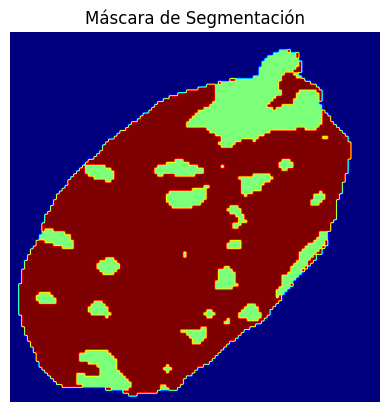

In [ ]:
import matplotlib.pyplot as plt

# Visualizar la máscara de salida
plt.imshow(output_mask, cmap='jet')  # Usa 'jet' o 'gray' según el resultado
plt.title("Máscara de Segmentación")
plt.axis('off')
plt.show()